In [1]:
from tools import (
    Batch,
    FunctionalModule,
    WarmupLR,
    piecewise_linear_log,
    spectrogram_transform,
)

from functools import partial
import torchaudio
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import sentencepiece as spm
import librosa

import sys

torch.manual_seed(42)
CUDA_DEVICE = 0

In [2]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [3]:
labels = pd.read_csv("train_labels.csv", index_col="Id")
labels

,Expected
Id,
0,лицо чуть широковатое с круглым и твердым подб...
1,я видел такое о чем не смею рассказать вам отв...
2,я быстро справилась с собой и попала ей в тон
3,заохал демидов
4,тут будут казнить кого то важного по меньшей м...
...,...
99995,куда вот только
99996,о да ответила элинор остерегаясь высказать сво...
99997,из за халатности работников милиции не сумевши...


## Создаем лексикон

In [4]:
#np.savetxt("spm/corpus.txt", labels['Expected'].values, fmt="%s")

In [5]:
#spm.SentencePieceTrainer.train(input="spm/corpus.txt", model_prefix='m', vocab_size=1024, model_type="bpe")

In [6]:
sp = spm.SentencePieceProcessor(model_file='spm/m1023.model')

### Пример работы с лексиконом

In [7]:
sp.encode("проект по курсу нейронных сетей", out_type=int)

[75, 987, 996, 991, 11, 246, 994, 286, 607, 16, 990, 209, 5, 33, 241]

In [8]:
sp.decode([75, 987, 996, 991, 11, 246, 994, 286, 607, 16, 990, 209, 5, 33, 241])

'проект по курсу нейронных сетей'

## Предобработка

### Предобработка фичей

In [9]:
_, sample_rate = torchaudio.load("train_wavs/0.wav")
__, sample_rate = torchaudio.load("train_wavs/1.wav")

In [10]:
n_fft = 512
win_length = int(0.025 * sample_rate)
hop_length = int(0.01 * sample_rate)
n_mels=40

win_length, hop_length

(400, 160)

In [11]:
melspec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    normalized=True
)

In [12]:
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=12,
    log_mels=False,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "win_length": win_length,
        "hop_length": hop_length,
        "normalized": True
    },
)

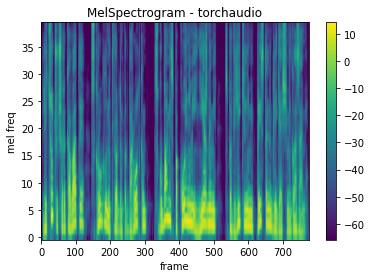

In [13]:
plot_spectrogram(melspec_transform(_)[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [14]:
train_data_pipeline = torch.nn.Sequential(
    #melspec_transform,
    FunctionalModule(partial(torch.transpose, dim0=1, dim1=2)),
    torchaudio.transforms.FrequencyMasking(10),
    torchaudio.transforms.TimeMasking(50, p=0.2),
    FunctionalModule(partial(torch.nn.functional.pad, pad=(0, 4))),
    FunctionalModule(partial(torch.transpose, dim0=1, dim1=2)),
)

valid_data_pipeline = torch.nn.Sequential(
    #melspec_transform,
    FunctionalModule(partial(torch.transpose, dim0=1, dim1=2)),
    FunctionalModule(partial(torch.nn.functional.pad, pad=(0, 4))),
    FunctionalModule(partial(torch.transpose, dim0=1, dim1=2)),
)

In [15]:
def get_batches(idx_target_lengths, token_limit):
    batches = []
    current_batch = []
    current_token_count = 0
    for idx, target_length in idx_target_lengths:
        if current_token_count + target_length > token_limit:
            batches.append(current_batch)
            current_batch = [idx]
            current_token_count = target_length
        else:
            current_batch.append(idx)
            current_token_count += target_length
    if current_batch:
        batches.append(current_batch)
    return batches

In [16]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, labels, sp_model, max_len, transform=None, spec_transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.sp_model = sp_model
        self.spec_transform = spec_transform
        self.labels = labels
        
        labels["Expected_length"] = labels["Expected"].apply(lambda x: len(x))
        labels = labels[labels["Expected_length"] < max_len]
        idx_target_lengths = labels.sort_values(by=["Expected_length"],
                                        ascending=True).reset_index()[["Id", "Expected_length"]].values
        self.bathes = get_batches(idx_target_lengths, max_len)
    
    def __len__(self):
        return len(self.bathes)
    
    def __getitem__(self, idx):
        return self.bathes[idx]
    
    def train_collate_fn(self, batch):
        batch = batch[0]
        
        waves = [torchaudio.load(f"{self.data_dir}{idx}.wav")[0] for idx in batch]
        mel_features = [self.spec_transform(wave.squeeze()).transpose(1, 0) for wave in waves]
        features = torch.nn.utils.rnn.pad_sequence(mel_features, batch_first=True)
        features = self.transform(features)
        
        feature_lengths = torch.tensor([mel_feature.shape[0] for mel_feature in mel_features], dtype=torch.int32)
        
        targets = [self.sp_model.encode(self.labels["Expected"][idx]) for idx in batch]
        target_lengths = torch.tensor([len(elem) for elem in targets]).to(dtype=torch.int32)
        targets = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(elem) for elem in targets],
            batch_first=True,
            padding_value=1.0,
        ).to(dtype=torch.int32)
        
        return (
            features.cuda(CUDA_DEVICE),
            feature_lengths.cuda(CUDA_DEVICE),
            targets.cuda(CUDA_DEVICE),
            target_lengths.cuda(CUDA_DEVICE)
        )

In [17]:
data_dir = "train_wavs/"
ds_train = TrainDataset(
    data_dir=data_dir,
    labels=labels,
    sp_model = sp,
    max_len=100,
    transform = train_data_pipeline,
    spec_transform = melspec_transform
)

In [18]:
dl_train = torch.utils.data.DataLoader(ds_train, collate_fn=ds_train.train_collate_fn, shuffle=True)

## Обучение

In [19]:
model = torchaudio.models.emformer_rnnt_model(
    input_dim=40,
    encoding_dim=1024,
    num_symbols=1024,
    segment_length=16,
    right_context_length=4,
    time_reduction_input_dim=128,
    time_reduction_stride=4,
    transformer_num_heads=8,
    transformer_ffn_dim=2048,
    transformer_num_layers=20,
    transformer_dropout=0.1,
    transformer_activation="gelu",
    transformer_left_context_length=30,
    transformer_max_memory_size=0,
    transformer_weight_init_scale_strategy="depthwise",
    transformer_tanh_on_mem=True,
    symbol_embedding_dim=512,
    num_lstm_layers=3,
    lstm_layer_norm=True,
    lstm_layer_norm_epsilon=1e-3,
    lstm_dropout=0.3,
).cuda(CUDA_DEVICE)

In [20]:
#model = torchaudio.models.emformer_rnnt_base(1025).cuda(CUDA_DEVICE)
decoder = torchaudio.models.RNNTBeamSearch(model, 1024)
criterion = torchaudio.transforms.RNNTLoss(reduction="sum", clamp=1.0).cuda(CUDA_DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-8)

### Загрузка состояния

In [21]:
checkpoint = torch.load("artifacts/model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

### Тренировка

In [21]:
%%time
train_loss = 0
epochs = 1

for epoch in range(epochs):
    
    for idx, batch in tqdm(enumerate(dl_train)):

        features, feature_lengths, targets, target_lengths = batch

        prepended_targets = targets.new_empty([targets.size(0), targets.size(1) + 1])
        prepended_targets[:, 1:] = targets
        prepended_targets[:, 0] = sp.get_piece_size()
        prepended_target_lengths = target_lengths + 1


        output, src_lengths, _, _ = model(
            features,
            feature_lengths,
            prepended_targets,
            prepended_target_lengths
        )


        loss = criterion(output, targets, src_lengths, target_lengths)
        train_loss += loss.data
        loss.backward()
        optimizer.step()

        if idx % 100 == 0 and idx != 0:
            train_loss /= 100
            print(f"train loss: {train_loss}")
            train_loss = 0

        if idx % 1000 == 0:
            torch.save({
                "epoch": epoch,
                "idx": idx,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }, "artifacts/model.pt")
            print(f"state saved: {idx * (epoch + 1)} batchs processed")
        

2it [00:04,  1.79s/it]

state saved: 0 batchs processed


101it [00:24,  4.70it/s]

train loss: 273.1378173828125


201it [00:45,  4.25it/s]

train loss: 234.44247436523438


302it [01:07,  4.83it/s]

train loss: 222.40701293945312


402it [01:28,  4.88it/s]

train loss: 213.93505859375


501it [01:49,  4.58it/s]

train loss: 211.95309448242188


602it [02:10,  4.75it/s]

train loss: 213.14524841308594


702it [02:31,  4.84it/s]

train loss: 202.20660400390625


802it [02:51,  4.97it/s]

train loss: 193.09014892578125


902it [03:12,  4.95it/s]

train loss: 202.70046997070312


1000it [03:32,  4.69it/s]

train loss: 199.41482543945312


1001it [03:34,  1.54it/s]

state saved: 1000 batchs processed


1102it [03:55,  4.79it/s]

train loss: 206.31277465820312


1202it [04:16,  4.64it/s]

train loss: 194.37966918945312


1302it [04:37,  4.81it/s]

train loss: 202.2477264404297


1402it [04:58,  4.87it/s]

train loss: 202.8173370361328


1501it [05:19,  4.88it/s]

train loss: 210.1762237548828


1602it [05:40,  4.64it/s]

train loss: 200.27267456054688


1702it [06:01,  4.80it/s]

train loss: 194.27890014648438


1802it [06:22,  4.68it/s]

train loss: 208.87713623046875


1901it [06:42,  4.65it/s]

train loss: 196.34681701660156


2000it [07:04,  4.70it/s]

train loss: 207.64129638671875


2002it [07:06,  1.95it/s]

state saved: 2000 batchs processed


2102it [07:27,  4.93it/s]

train loss: 198.95643615722656


2202it [07:48,  4.67it/s]

train loss: 199.96290588378906


2301it [08:08,  4.66it/s]

train loss: 201.63499450683594


2402it [08:33,  4.59it/s]

train loss: 201.280029296875


2501it [08:57,  3.93it/s]

train loss: 198.41183471679688


2601it [09:20,  4.53it/s]

train loss: 199.94113159179688


2702it [09:41,  4.89it/s]

train loss: 194.75445556640625


2802it [10:02,  4.33it/s]

train loss: 195.76763916015625


2901it [10:23,  4.80it/s]

train loss: 200.53909301757812


3000it [10:44,  4.95it/s]

train loss: 198.40611267089844


3001it [10:45,  1.52it/s]

state saved: 3000 batchs processed


3101it [11:07,  4.24it/s]

train loss: 200.72679138183594


3202it [11:28,  4.75it/s]

train loss: 199.48263549804688


3301it [11:48,  4.14it/s]

train loss: 198.29962158203125


3401it [12:09,  4.80it/s]

train loss: 195.42608642578125


3501it [12:29,  4.31it/s]

train loss: 186.8471221923828


3601it [12:51,  4.46it/s]

train loss: 204.42161560058594


3702it [13:12,  4.61it/s]

train loss: 201.677001953125


3801it [13:33,  4.52it/s]

train loss: 203.0915985107422


3901it [13:55,  4.30it/s]

train loss: 198.12046813964844


4000it [14:16,  4.47it/s]

train loss: 197.2274169921875


4002it [14:18,  1.90it/s]

state saved: 4000 batchs processed


4101it [14:40,  3.58it/s]

train loss: 193.4494171142578


4125it [14:45,  4.66it/s]


KeyboardInterrupt: 

## Предсказание

In [23]:
elem = next(iter(dl_train))

In [24]:
decoder = torchaudio.models.RNNTBeamSearch(model, 1023)

In [25]:
out = decoder(elem[0][0], elem[1][0], 20)

In [28]:
sp.decode(out[0].tokens[1:])

''

In [27]:
sp.decode(elem[2].tolist())

['глаза у нее подозрительно поблескивали',
 'похоже он очень увлекся замечает воорт']

In [36]:
out[0].score

-2.222548246383667